<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [137]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [138]:
PATH_TO_DATA = 'C:/Users/HP/Desktop/CAPSTONE_WEB_IDENTIFICATION/OM'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [139]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
 
    with open(site_freq_path, 'rb') as f:
        site_dict = pickle.load(f)
    list_of_sessions = [] 
 
    list_of_files = sorted(glob(os.path.join(path_to_csv_files, '*'))) 
       
    for file in tqdm_notebook(list_of_files):       
        data = pd.read_csv(file)      
 
        list_of_sites = data.site.values
        list_of_times = [pd.to_datetime(timestamp) for timestamp in data.timestamp.values]        
        sess = {}
        
        for i in range(0, len(list_of_sites), window_size):
            sess['target'] = int(file.strip('.csv')[-4:])
            session_times = list_of_sites[i: i + session_length]              
              
            for j, site in enumerate(session_times):
                sess['site{}'.format(j + 1)] = site_dict[site][0]                    
          
            unique_sites = np.unique(session_times).shape[0]
            timespans = list_of_times[i: i + session_length]           
            for t, timestamp in enumerate(timespans[:-1]):
                sess['time_diff{}'.format(t + 1)] = (timespans[t + 1] - timestamp).total_seconds()
 
            sess['session_timespan'] = (timespans[-1] - timespans[0]).total_seconds()
            sess['#unique_sites'] = unique_sites
            sess['start_hour'] = timespans[0].hour
            sess['day_of_week'] = timespans[0].weekday()        
            list_of_sessions.append(sess)
            sess = {}
    train_data = pd.DataFrame(list_of_sessions, columns=feature_names).fillna(0).astype(int)
    return train_data
 

**Проверим функцию на игрушечном примере.**

In [140]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [141]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [142]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)


Wall time: 57.3 s


In [143]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [144]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)


Wall time: 12min 19s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [145]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [146]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [147]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [148]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

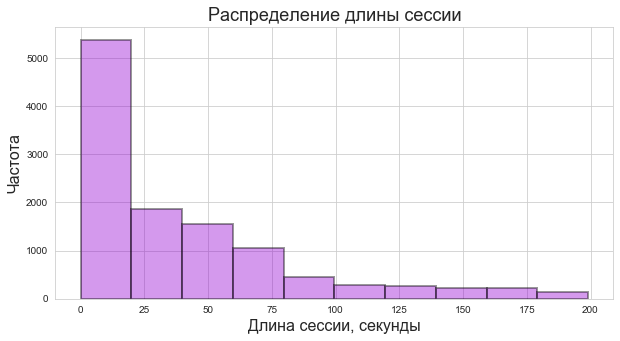

In [149]:
x = train_data_10users[train_data_10users.session_timespan < 200].session_timespan

with sns.axes_style('whitegrid'):
    
    plt.figure(figsize=(10, 5))
    sns.distplot(x, hist_kws=dict(edgecolor="black", linewidth=2), color='darkviolet', kde=False, bins=10)
    plt.xlabel("Длина сессии, секунды",fontsize=16)
    plt.ylabel("Частота",fontsize=16)
    plt.title(r"Распределение длины сессии",fontsize=18)
    plt.show();

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

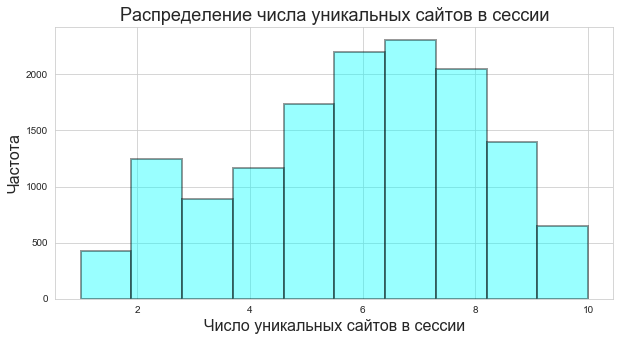

In [150]:
x = train_data_10users['#unique_sites']

with sns.axes_style('whitegrid'):
    
    plt.figure(figsize=(10, 5))
    sns.distplot(x, hist_kws=dict(edgecolor="black", linewidth=2),color='aqua', kde=False, bins=10)
    plt.xlabel("Число уникальных сайтов в сессии", fontsize=16)
    plt.ylabel("Частота", fontsize=16)
    plt.title(r"Распределение числа уникальных сайтов в сессии",fontsize=18)
    plt.show();

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

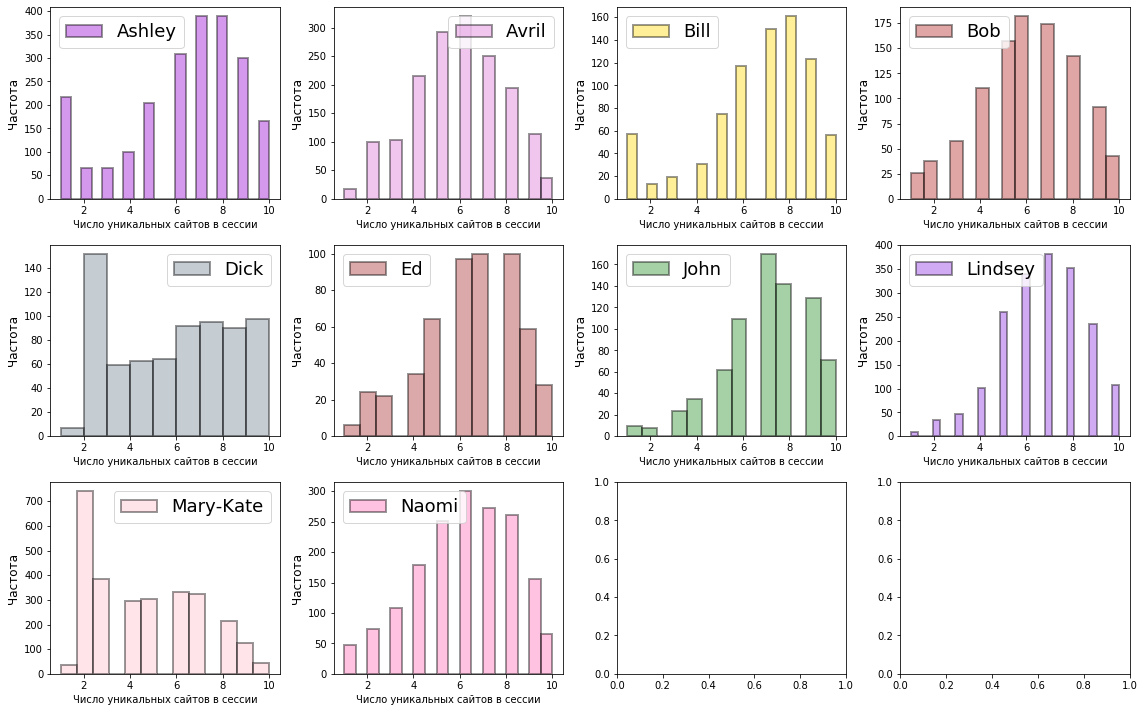

In [151]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    sns.distplot(sub_df['#unique_sites'], hist_kws=dict(edgecolor="black", linewidth=2, range=(1, 10)), kde=False, color=color_dic[user], ax=axes[idx//4, idx%4])    
    axes[idx//4, idx%4].set_xlabel('Число уникальных сайтов в сессии', fontsize=10)
    axes[idx//4, idx%4].set_ylabel('Частота', fontsize=12)
    axes[idx//4, idx%4].legend([user], fontsize=18)
plt.tight_layout()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

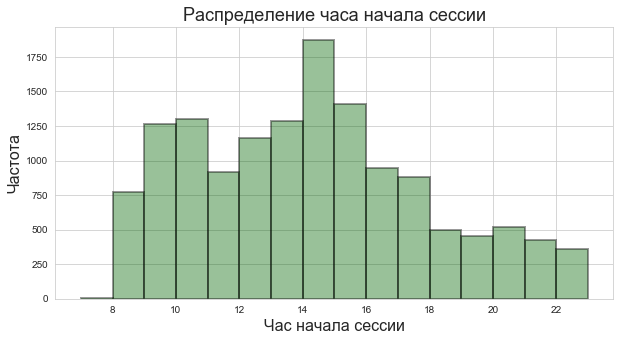

In [152]:
with sns.axes_style('whitegrid'):
    bins = range(train_data_10users.start_hour.min(), 
             train_data_10users.start_hour.max() + 1)
    x = train_data_10users['start_hour']
    plt.figure(figsize=(10, 5))
    sns.distplot(x, hist_kws=dict(edgecolor="black", linewidth=2), bins=bins,color='darkgreen', kde=False)
    plt.xlabel("Час начала сессии",fontsize=16)
    plt.ylabel("Частота",fontsize=16)
    plt.title(r"Распределение часа начала сессии",fontsize=18)
    plt.show();

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

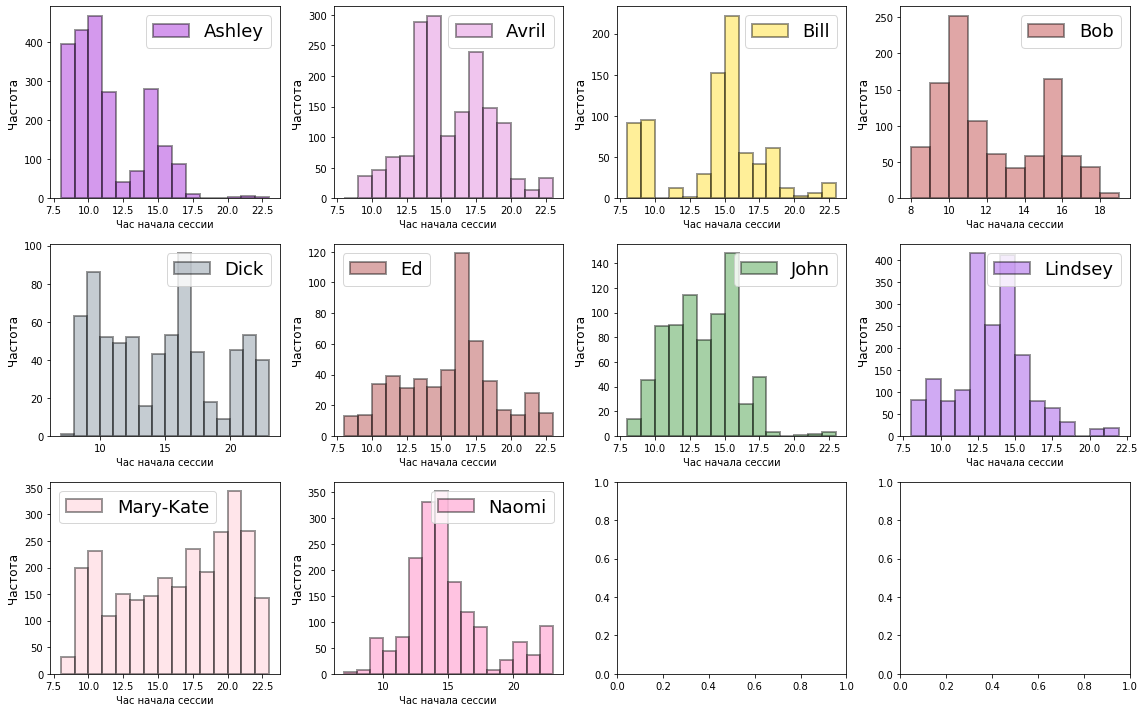

In [153]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    bins = range(sub_df.start_hour.min(), sub_df.start_hour.max() + 1)
    sns.distplot(sub_df['start_hour'], hist_kws=dict(edgecolor="black", linewidth=2, range=(1, 10)), bins=bins, kde=False, color=color_dic[user], ax=axes[idx//4, idx%4])    
    axes[idx//4, idx%4].set_xlabel('Час начала сессии', fontsize=10)
    axes[idx//4, idx%4].set_ylabel('Частота', fontsize=12)
    axes[idx//4, idx%4].legend([user], fontsize=18)
plt.tight_layout()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

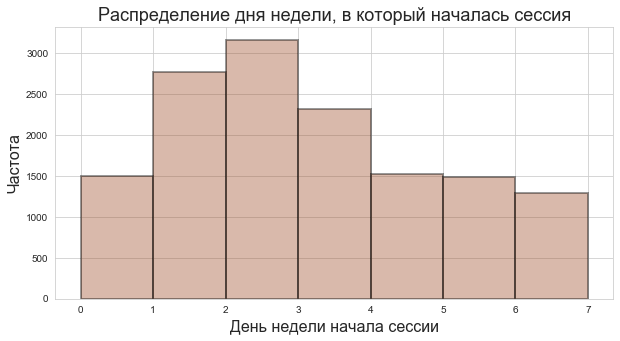

In [154]:
with sns.axes_style('whitegrid'):
    bins = range(train_data_10users.day_of_week.min(), 
             train_data_10users.day_of_week.max() + 2)
    x = train_data_10users['day_of_week']
    plt.figure(figsize=(10, 5))
    sns.distplot(x, hist_kws=dict(edgecolor="black", linewidth=2), bins=bins,color='sienna', kde=False)
    plt.xlabel("День недели начала сессии",fontsize=16)
    plt.ylabel("Частота",fontsize=16)
    plt.title(r"Распределение дня недели, в который началась сессия",fontsize=18)
    plt.show();

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

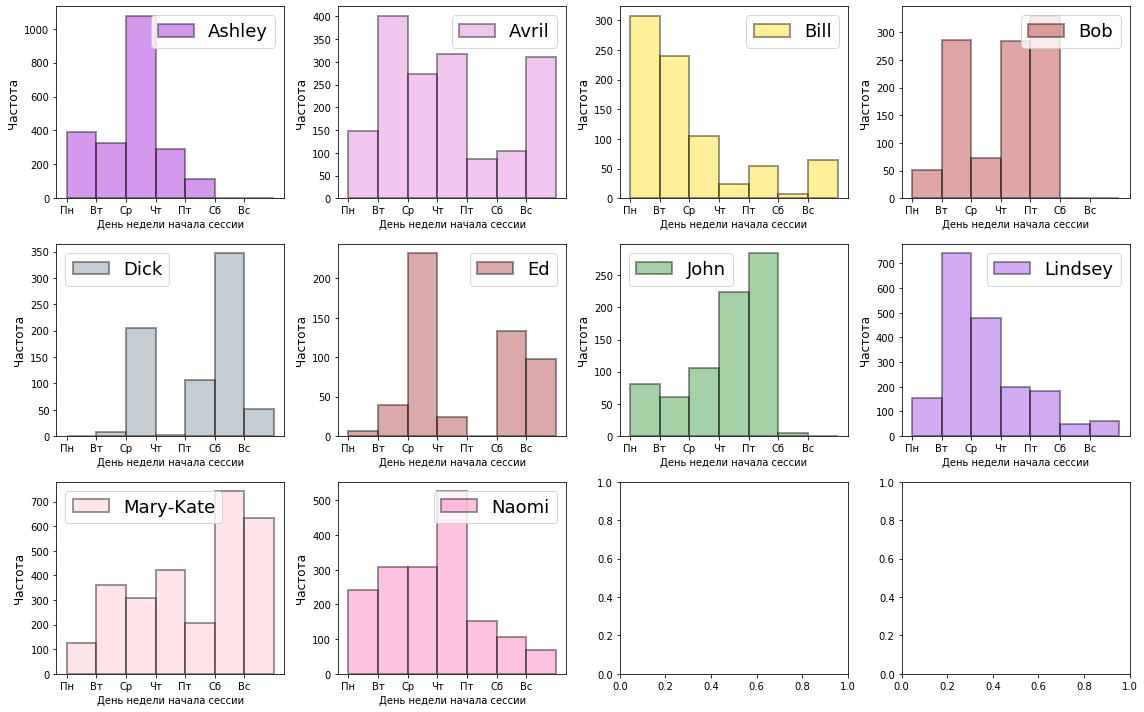

In [155]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('target')): 
    sns.distplot(sub_df['day_of_week'], hist_kws=dict(edgecolor="black", linewidth=2, range=(0, 7)), bins=7, kde=False, color=color_dic[user], ax=axes[idx//4, idx%4])    
    axes[idx//4, idx%4].set_xlabel('День недели начала сессии', fontsize=10)
    axes[idx//4, idx%4].set_ylabel('Частота', fontsize=12)
    axes[idx//4, idx%4].set_xticks(np.arange(7))
    axes[idx//4, idx%4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    axes[idx//4, idx%4].legend([user], fontsize=18)
plt.tight_layout()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Построенные графики позволяют сделать следующие выводы по нашим ***нареченным*** пользователям.

##### Ashley  
В выходные дни занимается более полезными делами чем серфить интернет. В среду отмечен пик активности. В 8 утра до полудня явно выраженная активность. В обеденный перерыв в иннтернет не выходит, и срау после обеда активность возрастает, и к концу рабочего дня активность спадает. 
Посещает разные сайты, но есть любимые.


##### Avril  
Активна на протяжении всей недели. В понедельник, пятницу и субботу активность снижается.
Пользуется интернетом на протяжениии всего дне до вечера. Пики активности  отмечены с 13:00 до 15:00, и с 17:00 до 18:00. Посещает разные сайты, но есть любимые.
                

##### Bill  
Начинает неделю невероятно активно и затем посещения постепенно снижаются. Меньше всего активность в четверг и субботу. Пик активности отмечаем c 14:00 до 16:00. Посещает разные сайты.

##### Bob 
В выходные не заходит в интернет. В будние дни наиболее активен во вторник, четверг и пятницу.
Пик активности отмечаем в 10:00 и в 15:00. Посещает разные сайты.

##### Dick 
Пик активности приходится на среду и на субботу. Понедельник видимо день тяжелый, не до интернета. Пользуется интернетом на протяжении всего дня. Спады отмечаются только во время обеда и во время ужина. Много сессий с двумя уникальными сайтами и некоторое количество сессий с большим числом уникальных сайтов.

##### Ed 

Зависает в интернете в среду и на выходных. Активен на протяжении всего светового дня, но проявляет суперактивность в 16:00. Посещает разные сайты.


##### John

Начинает рабочую неделю с посещения интернета и активность возрастает на протяжении недели. В выходные практически обходится без интернета. Джон пользуется интернетом преимущественно в рабочие часы. Посещает разные сайты.



##### Lindsey
Главным образом посещает интернет по вторникам и средам. Наиболее активна в дневное время.  Пики активности отмечены в 12:00 и в 14:00. Посещает в основном разные сайты.


##### Mary-Kate

Наибольшая активность отмечена в выходные дни, минимальная в понедельник. Использует интернет на протяжении всего светового дня с ростом активности с утра до 20:00. Большое количество сессий с одним-двумя уникальными сайтами. 
 
##### Naomi

Выходит в интернет во все дни недели. С понедельника по четверг рост активности,далее активность идет на спад. В середине рабочего дня проявляет наибольшую активность. Посещает разные сайты.



**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [156]:

with open('site_freq_10users.pkl', 'rb') as f:
    site_freq_10users = pickle.load(f)
 

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [157]:
top10_freqs = [val[1] for val in list(site_freq_10users.values())][:10]
top10_freqs

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]

In [158]:
top10_sites = list(site_freq_10users.keys())[:10]
top10_sites

['s.youtube.com',
 'www.google.fr',
 'www.google.com',
 'mail.google.com',
 'www.facebook.com',
 'apis.google.com',
 'r3---sn-gxo5uxg-jqbe.googlevideo.com',
 'r1---sn-gxo5uxg-jqbe.googlevideo.com',
 'plus.google.com',
 'accounts.google.com']

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

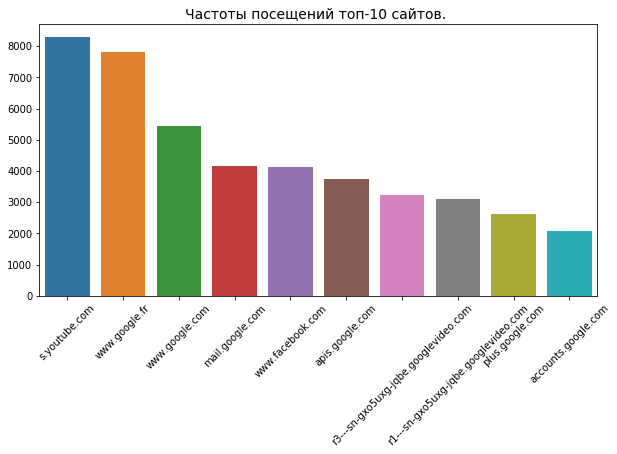

In [159]:
plt.figure(figsize=(10, 5))
sns.barplot(top10_sites,top10_freqs)
plt.xticks(rotation=45)
plt.title(r"Частоты посещений топ-10 сайтов. ",fontsize=14)
plt.show();

###### Мне кажется горизонтальный barplot  в данном случае более подходит.

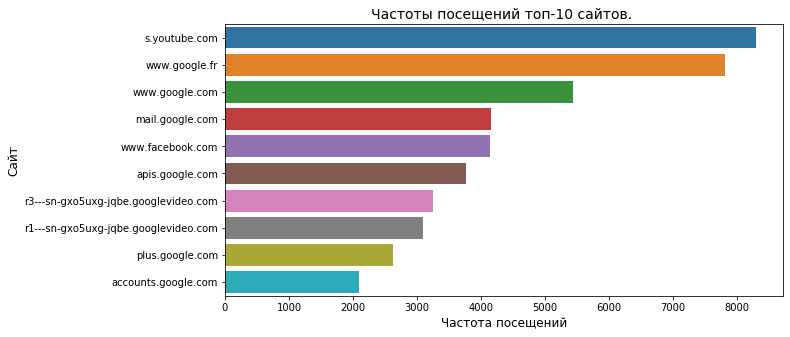

In [160]:
plt.figure(figsize=(10, 5))
sns.barplot(top10_freqs,top10_sites)
plt.xlabel("Частота посещений",fontsize=12)
plt.ylabel("Сайт",fontsize=12)
plt.title(r"Частоты посещений топ-10 сайтов. ",fontsize=14)
plt.show();

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [161]:
train_data_10users.session_timespan.median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [162]:
 
train_data_10users.day_of_week.median()



2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [163]:
 

train_data_150users.start_hour.median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [164]:
 
train_data_150users['#unique_sites'].median()
 

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [171]:
def feature_engineering(path_to_csv_files, site_freq_path, 
                        features, session_length=10, window_size=10):
    list_of_sessions = []
    top30_sites = list(site_freq_10users.keys())[:30]
    list_of_files = sorted(glob(os.path.join(path_to_csv_files, '*')))
 
    for user in tqdm_notebook(list_of_files):
        data = pd.read_csv(user)
        list_of_sites = data.site.values
        list_of_times = [pd.to_datetime(timestamp) for timestamp in data.timestamp.values]
         
        sess = {}  
        for i in range(0, len(list_of_sites), window_size):
            sess['trending_sites'] = 0
            sess['trending_sites_time'] = 0
            session_times = list_of_sites[i: i + session_length]
            timespans = list_of_times[i: i + session_length]
            
            for site in session_times:
                if site in top30_sites:
                    sess['trending_sites'] += 1
                else:
                    continue
                    
            for j, timestamp in enumerate(timespans[:-1]):
                if session_times[j] in top30_sites:
                    sess['trending_sites_time'] += (timespans[j + 1] - timestamp).total_seconds()
                else:
                    continue
                    
            sess['target'] = int(user.strip('.csv')[-4:])
            list_of_sessions.append(sess)
            sess = {}
    
    train_data = pd.DataFrame(list_of_sessions, columns=features).fillna(0).astype(int)
    return train_data         

In [172]:
new_features_2_10users = feature_engineering(
        path_to_csv_files=os.path.join(PATH_TO_DATA, '10users'), 
        site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
        features=['trending_sites', 'trending_sites_time', 'target'], 
        session_length=10, window_size=10) 

In [178]:
new_features_2_10users.head()

,trending_sites,trending_sites_time,target
0,2,1,31
1,0,0,31
2,2,14,31
3,0,0,31
4,1,1,31


In [179]:

new_features_2_150users = feature_engineering(
        path_to_csv_files=os.path.join(PATH_TO_DATA, '150users'), 
        site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
        features=['trending_sites', 'trending_sites_time', 'target'], 
        session_length=10, window_size=10) 

In [181]:
new_features_2_150users.sample(5)

,trending_sites,trending_sites_time,target
16434,10,47,85
25352,3,3,106
120871,2,36,932
64427,5,5,308
16240,0,0,85


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

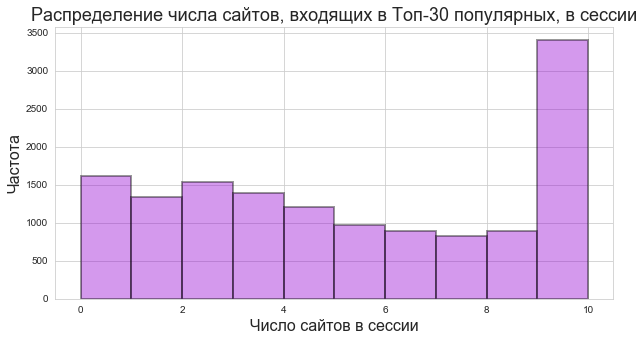

In [174]:
x = new_features_2_10users['trending_sites']

with sns.axes_style('whitegrid'):
    
    plt.figure(figsize=(10, 5))
    sns.distplot(x, hist_kws=dict(edgecolor="black", linewidth=2, range=(0, 10)),color='darkviolet', kde=False, bins=10)
    plt.xlabel("Число сайтов в сессии", fontsize=16)
    plt.ylabel("Частота", fontsize=16)
    plt.title(r"Распределение числа сайтов, входящих в Топ-30 популярных, в сессии",fontsize=18)
    plt.show();

### Распределения числа сайтов, входящих в Топ-30 популярных, в сессии

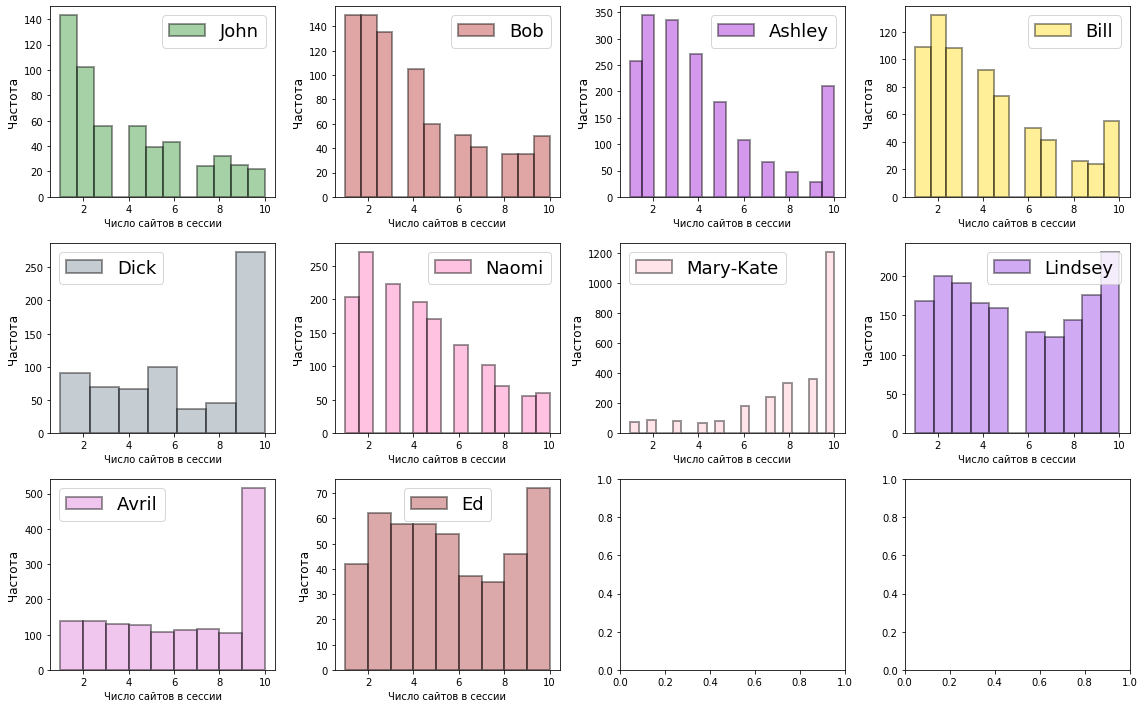

In [182]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(new_features_2_10users.groupby('target')): 
    sns.distplot(sub_df['trending_sites'], hist_kws=dict(edgecolor="black", linewidth=2, range=(1, 10)), kde=False, color=color_dic[id_name_dict[user]], ax=axes[idx//4, idx%4])    
    axes[idx//4, idx%4].set_xlabel('Число сайтов в сессии', fontsize=10)
    axes[idx//4, idx%4].set_ylabel('Частота', fontsize=12)
    axes[idx//4, idx%4].legend([id_name_dict[user]], fontsize=18)
plt.tight_layout()


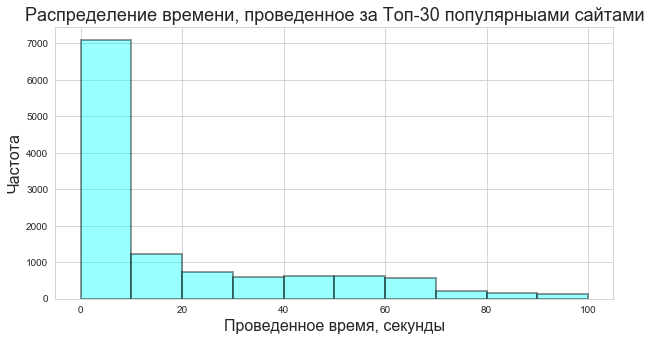

In [176]:
x = new_features_2_10users['trending_sites_time']

with sns.axes_style('whitegrid'):
    
    plt.figure(figsize=(10, 5))
    sns.distplot(x, hist_kws=dict(edgecolor="black", linewidth=2, range=(0, 100)),color='aqua', kde=False, bins=10)
    plt.xlabel("Проведенное время, секунды", fontsize=16)
    plt.ylabel("Частота", fontsize=16)
    plt.title(r"Распределение времени, проведенное за Топ-30 популярныами сайтами", fontsize=18)
    plt.show();

### Распределение времени, проведенного за Топ-30 популярными сайтами

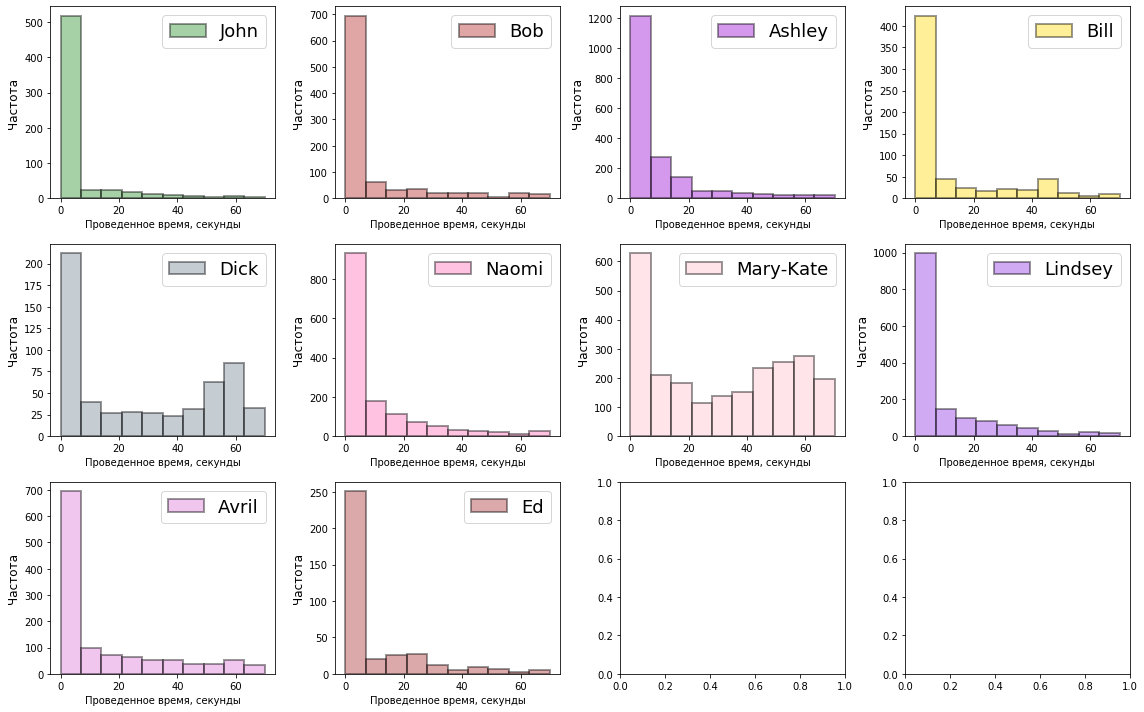

In [184]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
 
for idx, (user, sub_df) in  enumerate(new_features_2_10users.groupby('target')): 
    sns.distplot(sub_df['trending_sites_time'], hist_kws=dict(edgecolor="black", linewidth=2, range=(0, 70)), bins=10, kde=False, color=color_dic[id_name_dict[user]], ax=axes[idx//4, idx%4])    
    axes[idx//4, idx%4].set_xlabel('Проведенное время, секунды', fontsize=10)
    axes[idx//4, idx%4].set_ylabel('Частота', fontsize=12)
    axes[idx//4, idx%4].legend([id_name_dict[user]], fontsize=18)
plt.tight_layout()



### Комментарий 

Построенные графики позволяют сделать следующие выводы по нашим ***нареченным*** пользователям.
 
- Пользователи в основном _всеядны_ в плане посещения популярных с сайтов, однако кто то из них главныым образом сидит на этих популярных сайтах, а кто то избегает.
 
- Во основном пользователи не засиживаются на популярных сайтах, кроме пожалуй одной девушки. 
 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [208]:
selected_features_10users = pd.concat([new_features_10users[["session_timespan","#unique_sites","start_hour","day_of_week"]], new_features_2_10users[["trending_sites", "trending_sites_time"]]],axis=1)
selected_features_10users.head()

,session_timespan,#unique_sites,start_hour,day_of_week,trending_sites,trending_sites_time
0,33,5,8,4,2,1
1,284,10,8,4,0,0
2,258,7,8,4,2,14
3,30,6,8,4,0,0
4,6,9,8,4,1,1


In [210]:
selected_features_150users = pd.concat([new_features_10users[["session_timespan","#unique_sites","start_hour","day_of_week"]], new_features_2_10users[["trending_sites", "trending_sites_time"]]],axis=1)
selected_features_150users.head()

,session_timespan,#unique_sites,start_hour,day_of_week,trending_sites,trending_sites_time
0,33,5,8,4,2,1
1,284,10,8,4,0,0
2,258,7,8,4,2,14
3,30,6,8,4,0,0
4,6,9,8,4,1,1


In [211]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 